팁: 혈맹의 공격성과 총결제량은 비례한다

In [33]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.pyplot  as plt
import seaborn as sns

train_payment = pd.read_csv('./train_payment.csv')
train_activity = pd.read_csv('./train_activity.csv')
train_combat = pd.read_csv('./train_combat.csv')
train_trade = pd.read_csv('./train_trade.csv')

train_pledge = pd.read_csv('./train_pledge.csv')
train_pledge = train_pledge.drop('non_combat_play_time',axis=1)
train_pledge.to_csv('./train_pledge.csv', index = False)

train_label = pd.read_csv('./train_label_add.csv')
train_label = train_label.sort_values('acc_id')

In [34]:
plg_lbl = pd.merge(train_pledge, train_label, on = 'acc_id', how="outer").fillna(0)

# 혈맹 아이디로 분석하기

In [612]:
plg_lbl = pd.merge(train_pledge, train_label, on = 'acc_id', how="inner")

In [615]:
plg_lbl.shape

(1083384, 18)

In [48]:
plg_count = plg_lbl.groupby('pledge_id').count().reset_index()
plg_sum = plg_lbl.groupby('pledge_id').sum().reset_index()

In [53]:
train_pledge[train_pledge['pledge_id']==2]

,day,acc_id,char_id,server,pledge_id,play_char_cnt,combat_char_cnt,pledge_combat_cnt,random_attacker_cnt,random_defender_cnt,same_pledge_cnt,temp_cnt,etc_cnt,combat_play_time
5557,1,39448,277729,ae,2,0.036089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
840541,23,39448,277729,ae,2,0.036089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
# 혈맹들의 규모와 상관없이 비교하기 위해 mean
plg_mean = plg_lbl.groupby('pledge_id').mean().reset_index().drop(['acc_id','char_id'],axis=1)

In [ ]:
plt.figure(figsize=(20,15))
plt.hist(plg_mean)
plt.show()
# 갑자기 안 뜨네요

In [619]:
# 상관관계 보기
c = plg_mean.corr()
c['total_spent']

pledge_id             -0.003331
day                   -0.034851
play_char_cnt         -0.033981
combat_char_cnt       -0.017881
pledge_combat_cnt      0.057920
random_attacker_cnt    0.031182
random_defender_cnt   -0.062123
same_pledge_cnt        0.043343
temp_cnt              -0.017216
etc_cnt                0.003028
combat_play_time      -0.068901
survival_time          0.328033
amount_spent           0.279690
secession             -0.323303
total_spent            1.000000
Name: total_spent, dtype: float64

------------

#  변수 추가 시작

## 주캐의 혈맹에 대한 변수 추가

In [620]:
train_combat.head()

,day,acc_id,char_id,server,class,level,pledge_cnt,random_attacker_cnt,random_defender_cnt,temp_cnt,same_pledge_cnt,etc_cnt,num_opponent
0,1,13809,54861,ap,2,13,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,1,13809,256332,ap,2,13,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,1,13809,307293,ap,3,14,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,1,13809,374964,ap,7,16,0.0,0.0,0.0,0.0,0.0,0.112612,0.098129
4,1,13809,117917,ap,2,11,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


In [623]:
# 주캐의 acc별 char id 리스트 만들기
level_max = train_combat[['acc_id','char_id','level']]
level_max = level_max.groupby(['acc_id', 'char_id']).max()
level_max = level_max.reset_index()
level_max.rename(columns={'level':'level_max'},inplace=True)
level_max = level_max.groupby(['acc_id']).max().reset_index()


# 주캐의 혈맹으로만 데이터 만들기
plg_allday = train_pledge.groupby(['pledge_id','acc_id','char_id']).sum().reset_index()

plg_max = pd.merge(level_max, plg_allday, on = ['acc_id','char_id'], how='left').fillna(0)

# 주캐의 혈맹 정보만 분리한 40000명 df
plg_max_acc = plg_max.groupby(['acc_id']).sum().reset_index().drop('char_id',axis=1)

## 부캐들의 혈맹 정보만 합치기 

In [633]:
second = train_activity[['acc_id','char_id','playtime']].groupby(['acc_id','char_id']).sum().reset_index()
second2 = pd.merge(second,level_max, on=['acc_id','char_id'], how='outer')

# 
second2 = second2[second2['level_max'].isnull()==True].drop('level_max',axis=1)

# 한 캐릭터로 복수의 혈맹을 가진 유저가 있어서 행이 늘어난다
plg_second = pd.merge(second2, plg_allday, on =['acc_id','char_id'], how='left')
# 부케가 없는 유저가 있어서 행이 28790
plg_second = plg_second.groupby('acc_id').sum().reset_index()

# 부캐의 혈맹 정보만 들어간 40000행 df
plg_second = pd.merge(plg_second, level_max[['acc_id','level_max']], on =['acc_id'], how='outer').fillna(0).drop(['char_id','playtime'],axis=1)

## 주캐, 부캐 컬럼 연산

In [416]:
plt_acc = pd.merge(plg_max_acc, plg_second, on =['acc_id','level_max']).drop(['pledge_id_x','pledge_id_y'],axis=1)

# 주캐 - 부캐
for col in ['day', 'play_char_cnt','combat_char_cnt', 'pledge_combat_cnt', 'random_attacker_cnt',
       'random_defender_cnt', 'same_pledge_cnt', 'temp_cnt', 'etc_cnt',
       'combat_play_time']:
    
    plt_acc['p_' + col + '_div'] =    plt_acc[col + '_y'] / (plt_acc[col + '_x']+ plt_acc[col + '_y'])
                                        


#plt_acc['p_play_char_diff'] = plt_acc['play_char_cnt_x'] - plt_acc['play_char_cnt_y']

## 개인의 혈맹전 참여 횟수와 혈맹의 혈맹전 참가 횟수

## 태정이 형의 변수들

In [439]:
# 가입한 혈맹의 순위
def preprocessing_pledge(pledge_dir, pay_dir):
    # file load
    tr_pledge = pd.read_csv(pledge_dir)
    pay = pd.read_csv(pay_dir)
    
 
    # 가입한 혈맹의 순위
    bbb = tr_pledge.pledge_id.value_counts().to_frame().reset_index()
    bbb.columns = ['pledge_id','count']
    bbb['rank'] = bbb['count'].rank(ascending = False, method = 'min')
    pledge_rank = {}
    # dictionary를 활용해 원데이터의 pledge_id에 rank값을 mapping
    for i, j in enumerate(list(bbb['rank'])):
        pledge_rank[bbb['pledge_id'][i]] = j
    tr_pledge['pledge_rank'] = tr_pledge['pledge_id'].map(pledge_rank)


    # 혈맹원의 합
    pledge_member_num = {}
    for i in tr_pledge.pledge_id:
        if i not in pledge_member_num.keys():
            pledge_member_num[i] = 0
        pledge_member_num[i] += 1
    tr_pledge['pledge_member_num'] = tr_pledge['pledge_id'].map(pledge_member_num)


    # acc_id 기준으로 데이터 압축
    group = tr_pledge.groupby(['acc_id', 'day']).sum().reset_index()
    groups = group.groupby(['acc_id']).sum().reset_index()
    # label 데이터 merge
    merge_df = groups.copy()


    # 접속일 변수 log_in_freq 생성
    freq = []
    for i in group.acc_id.unique():
        freq.append([i,group[group.acc_id == i].shape[0]])
    new = pd.DataFrame(sorted(freq))
    new.columns = ['acc_id', 'log_in_freq']
    merge_df = pd.merge(merge_df, new, how = 'left', on = 'acc_id')
    return merge_df

In [440]:
tj =preprocessing_pledge('./train_pledge.csv', './train_payment.csv')

## 혈맹 유형 분류

## 부캐의 평균 레벨

In [518]:
combat_allday = train_combat[['acc_id','char_id','day','level']].groupby(['acc_id','char_id']).mean().reset_index()

# 소수점이 나오는 이유는 레벨업한 사람이 있기 떄문이다.
second_lvl = pd.merge(second2,combat_allday[['acc_id','char_id','level']], on=['acc_id','char_id'], how = 'left')
second_lvl_mean = second_lvl[['acc_id','char_id','level']].groupby(['acc_id']).mean().reset_index().drop(['char_id'],axis=1)
second_lvl_mean = second_lvl_mean.rename(columns = {'level':'second_lvl_mean'})

## 유저의 혈맹 개수

In [553]:
plg_count = train_pledge[['acc_id', 'pledge_id']].sort_values(['acc_id'])
plg_count = plg_count.drop_duplicates()
plg_count = plg_count.groupby('acc_id').count().reset_index()
plg_count = plg_count.rename(columns = {'pledge_id':'plg_count'})

## 유저의 메인 혈맹

## 이벤트(공성전) 서버로 추정되는 b서버 접속 횟수 

-------------

In [220]:
# 기존에 모두 더하던 방식
compare =train_pledge.groupby('acc_id').sum().reset_index()
compare_lbl = pd.merge(compare, train_label,on='acc_id',how='outer').fillna(0).sort_values(['acc_id'], ascending=True)
co = compare_lbl.corr()
co['total_spent'].sort_values(ascending=False)

total_spent            1.000000
survival_time          0.279657
amount_spent           0.266910
same_pledge_cnt        0.252391
pledge_combat_cnt      0.249304
combat_char_cnt        0.229083
day                    0.199509
etc_cnt                0.198906
combat_play_time       0.197599
random_attacker_cnt    0.196731
temp_cnt               0.184031
char_id                0.174339
pledge_id              0.172548
play_char_cnt          0.171327
acc_id                 0.005891
random_defender_cnt    0.005828
secession             -0.266477
Name: total_spent, dtype: float64

## 모델로 변수 평가하는 부분

In [558]:
plg_data = plt_acc_lbl2.drop(['secession','survival_time','amount_spent','total_spent'],axis=1)
#plg_data = plt_acc_lbl[['p_day_div',
 #      'p_play_char_cnt_div', 'p_combat_char_cnt_div',
 #      'p_pledge_combat_cnt_div', 'p_random_attacker_cnt_div',
 #      'p_random_defender_cnt_div', 'p_same_pledge_cnt_div', 'p_temp_cnt_div',
 #      'p_etc_cnt_div', 'p_combat_play_time_div']]

In [559]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(plg_data[plg_data.columns[1:]], plt_acc_lbl2['total_spent'], test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train.shape, X_test.shape, X_valid.shape , y_train.shape, y_test.shape, y_valid.shape

((21000, 36), (12000, 36), (7000, 36), (21000,), (12000,), (7000,))

In [560]:
import xgboost as xgb

params =   {
    'learning_rate': 0.02, 
    'gamma' : 0.3, 
    'min_child_weight' : 3,
    'nthread' : 15,
    'max_depth' : 30,
    'subsample' : 0.9,
    'eval_metric' : 'rmse',
    'colsample_bytree' : 0.8, 
    'num_boost_round' : 500,
    'n_estimators': 200,
    'max_leaves': 300,
    'objective': 'reg:linear'
}

In [561]:
VALID = True
if VALID == True:

    tr_data = xgb.DMatrix(X_train, y_train)
    va_data = xgb.DMatrix(X_valid, y_valid)

    

    watchlist = [(tr_data, 'train'), (va_data, 'valid')]

    model_0 = xgb.train(params, tr_data, 500, watchlist, maximize=False, 
                      early_stopping_rounds = 30, verbose_eval=50)

C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:46:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:7.52487	valid-rmse:7.46767
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:4.34114	valid-rmse:6.21905
[100]	train-rmse:2.88252	valid-rmse:6.04586
Stopping. Best iteration:
[115]	train-rmse:2.62426	valid-rmse:6.04093



In [562]:
y_pred = model_0.predict(xgb.DMatrix(X_test))

In [563]:
pred = y_test.reset_index()
pred['pred'] = y_pred

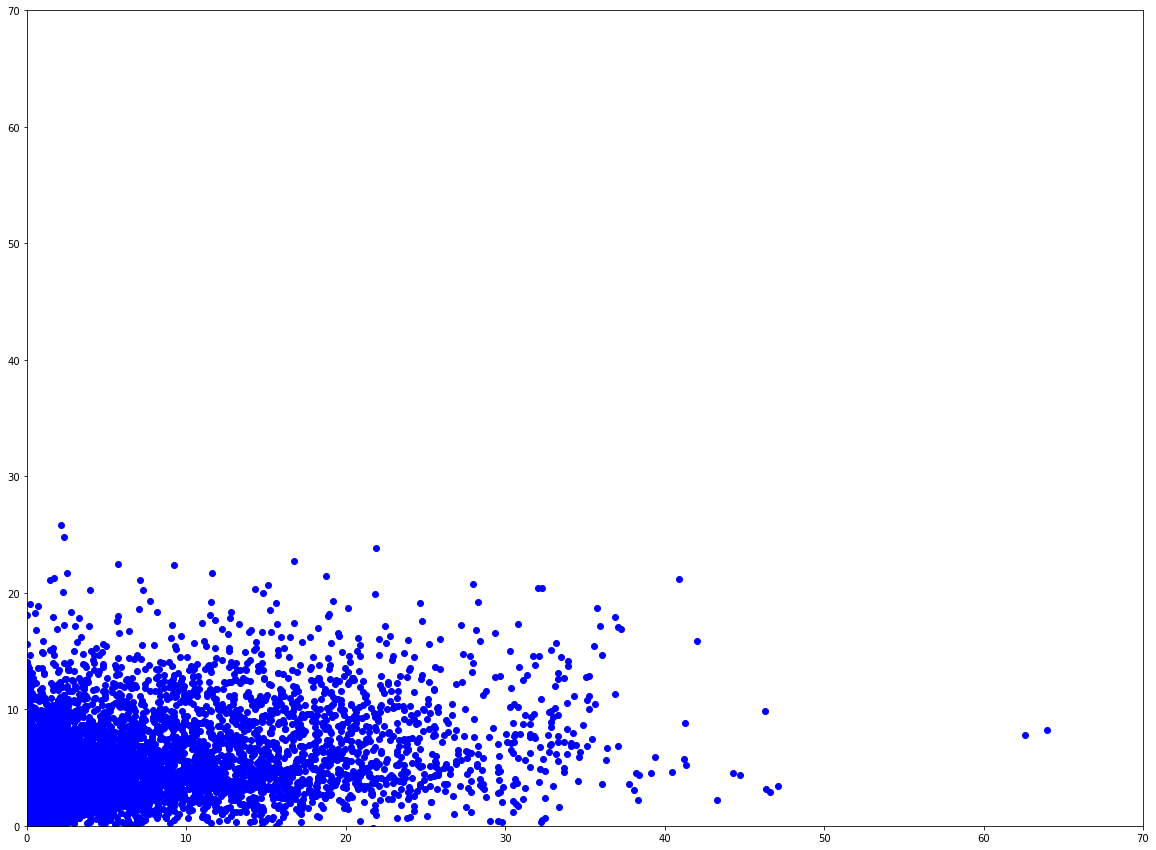

6.058977934834514


In [564]:
# 참여 혈맹 개수 추가
from sklearn.metrics import mean_squared_error as mse
plt.figure(figsize=(20,15))

plt.plot(pred['total_spent'],pred['pred'],'bo')
plt.axis([0, 70, 0, 70]); plt.show()
linreg_RMSE = np.sqrt(mse(pred['pred'], pred['total_spent']))
print(linreg_RMSE)

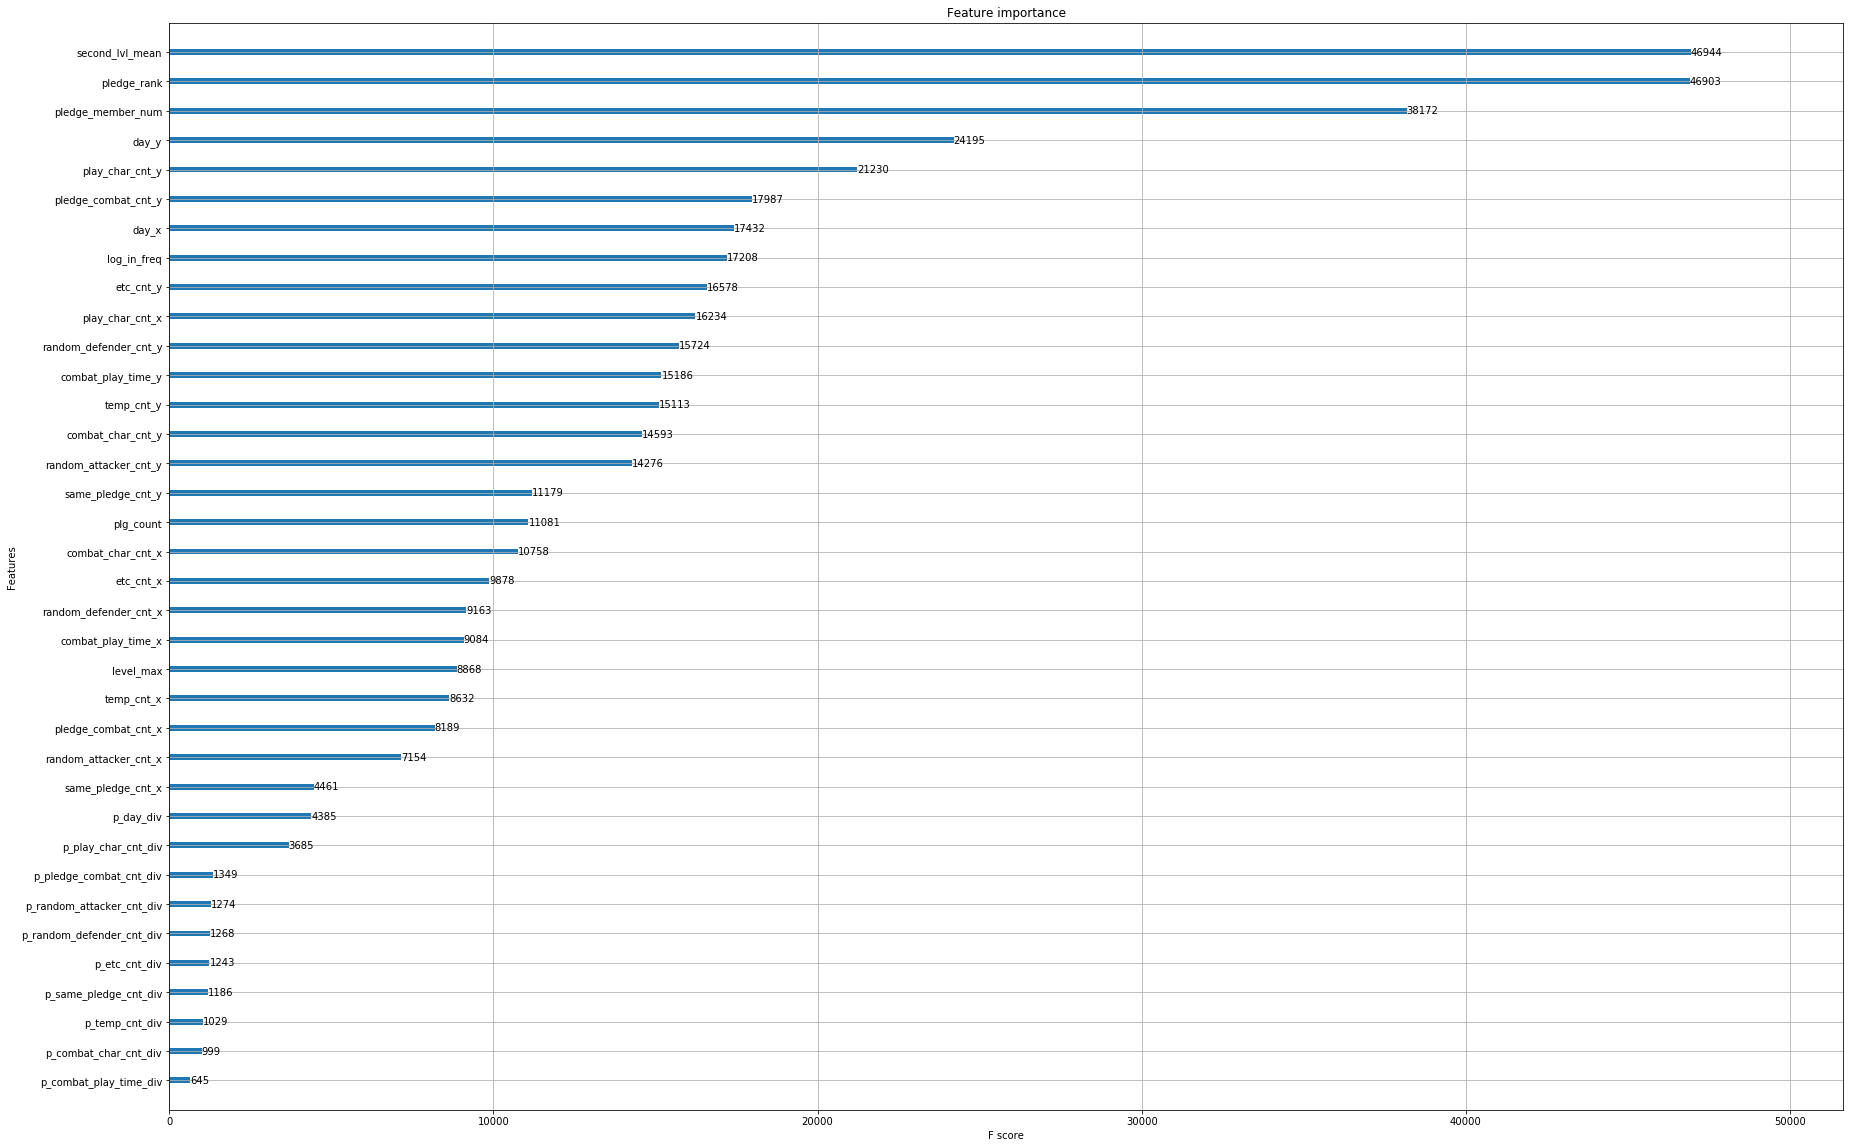

In [565]:
# 참여 혈맹 개수 추가

from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(30,20))
xgb.plot_importance(model_0,ax=ax)
plt.show()

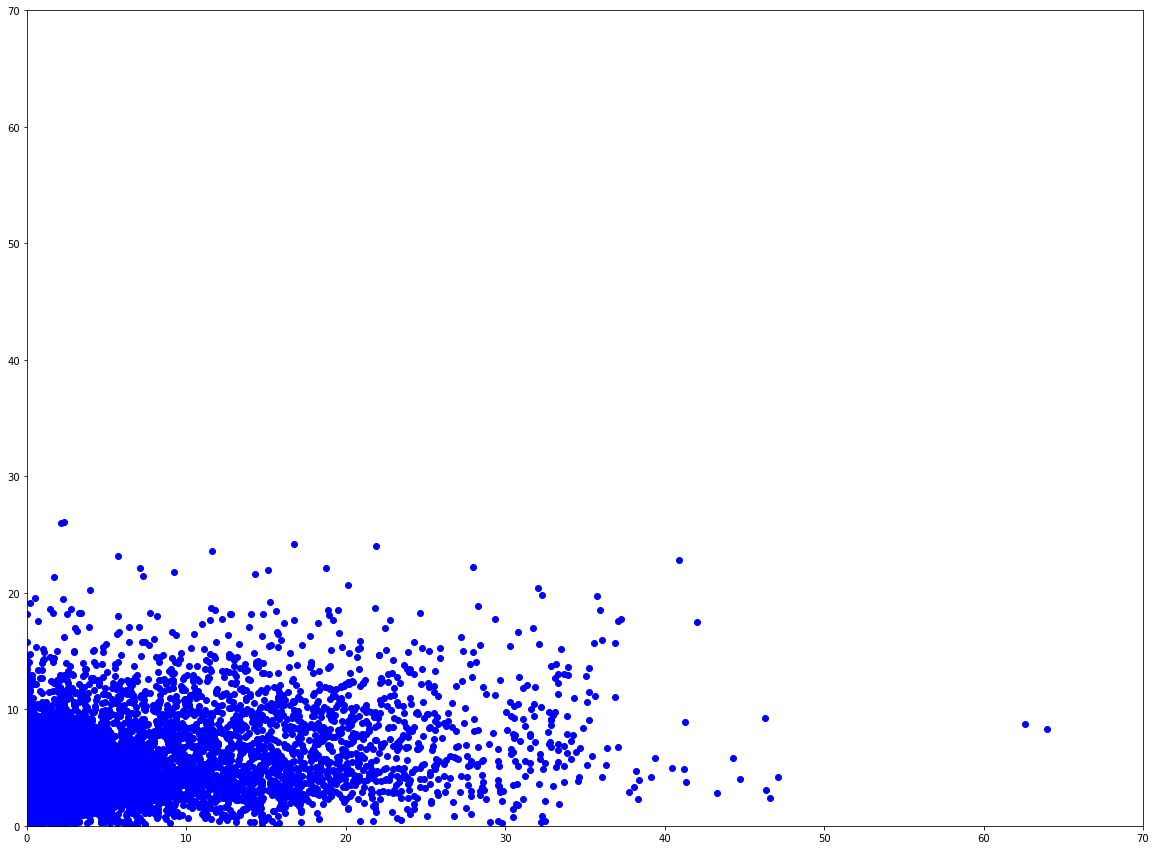

6.062295742127304


In [537]:
# 부캐 평균 레벨 추가
from sklearn.metrics import mean_squared_error as mse
plt.figure(figsize=(20,15))

plt.plot(pred['total_spent'],pred['pred'],'bo')
plt.axis([0, 70, 0, 70]); plt.show()
linreg_RMSE = np.sqrt(mse(pred['pred'], pred['total_spent']))
print(linreg_RMSE)

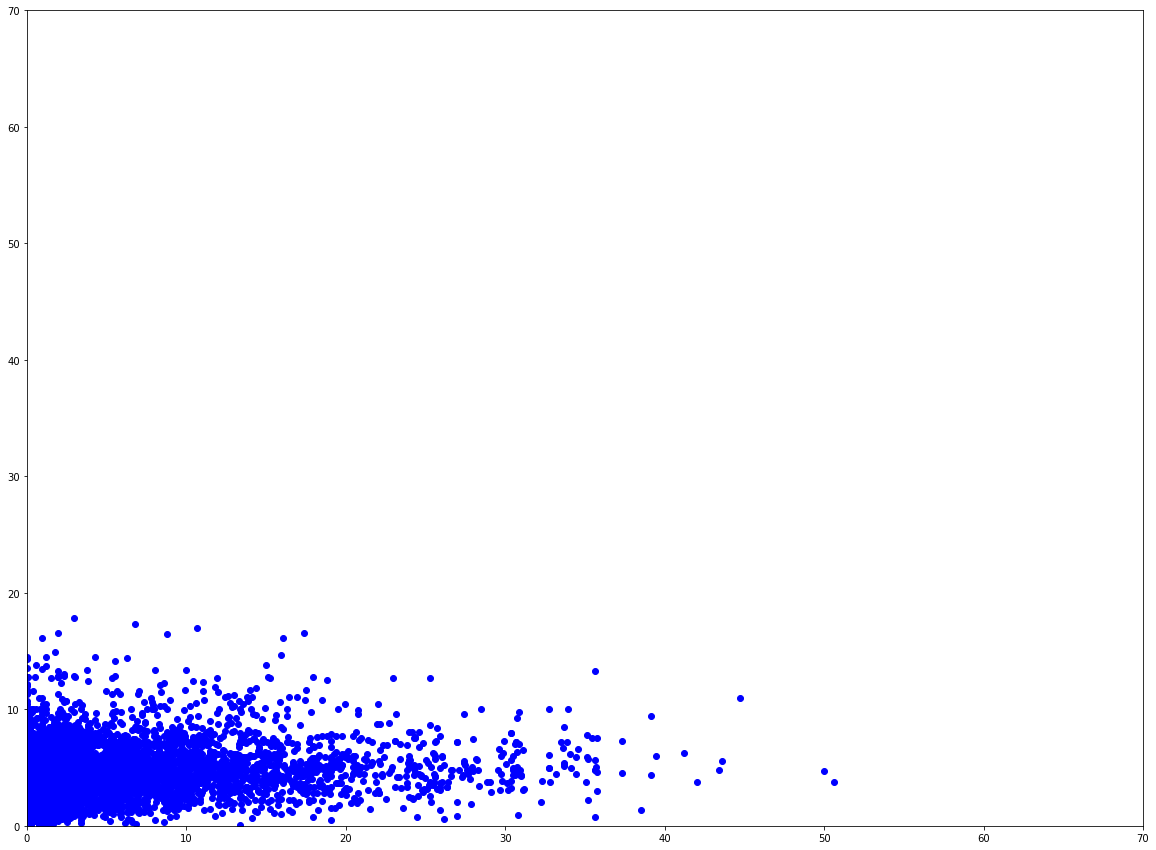

6.612466278446492


In [467]:
# 평균으로 한 결과
from sklearn.metrics import mean_squared_error as mse
plt.figure(figsize=(20,15))

plt.plot(pred['total_spent'],pred['pred'],'bo')
plt.axis([0, 70, 0, 70]); plt.show()
linreg_RMSE = np.sqrt(mse(pred['pred'], pred['total_spent']))
print(linreg_RMSE)

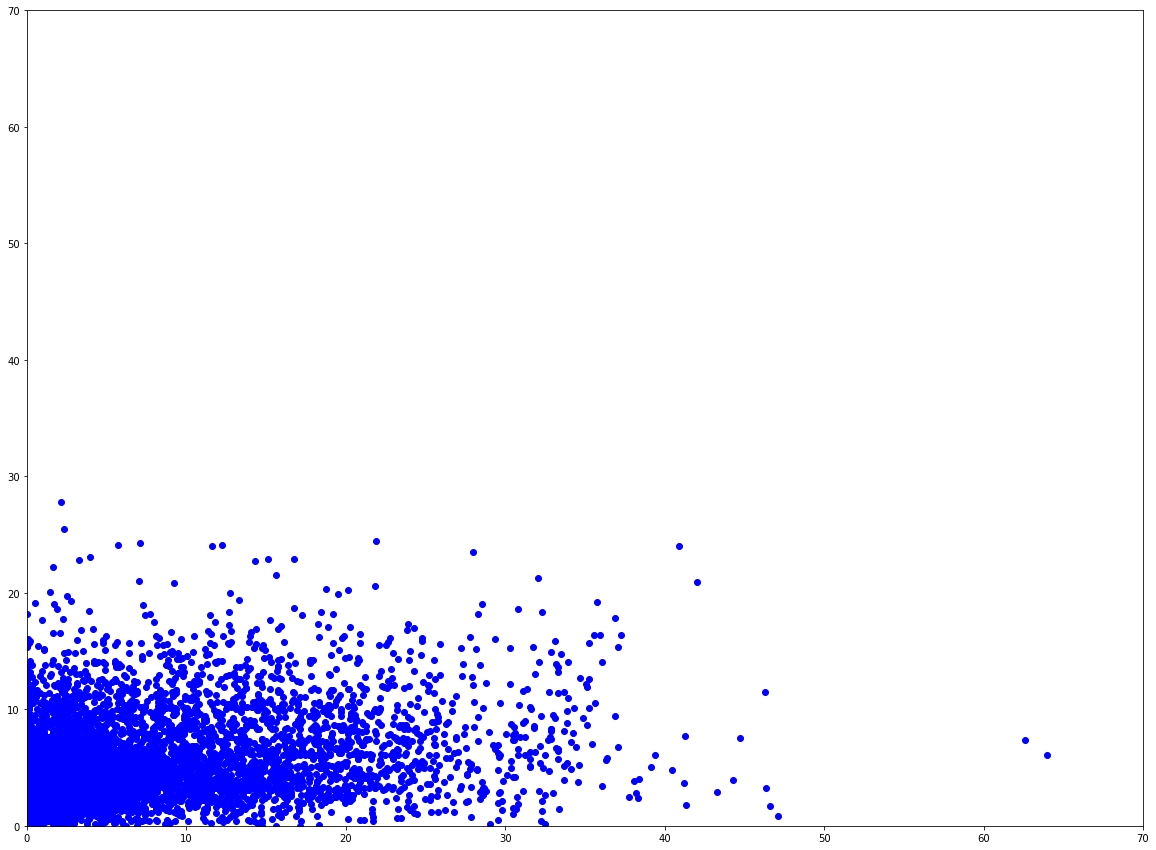

6.078512314386205


In [455]:
# 태정형꺼 추가
from sklearn.metrics import mean_squared_error as mse
plt.figure(figsize=(20,15))

plt.plot(pred['total_spent'],pred['pred'],'bo')
plt.axis([0, 70, 0, 70]); plt.show()
linreg_RMSE = np.sqrt(mse(pred['pred'], pred['total_spent']))
print(linreg_RMSE)

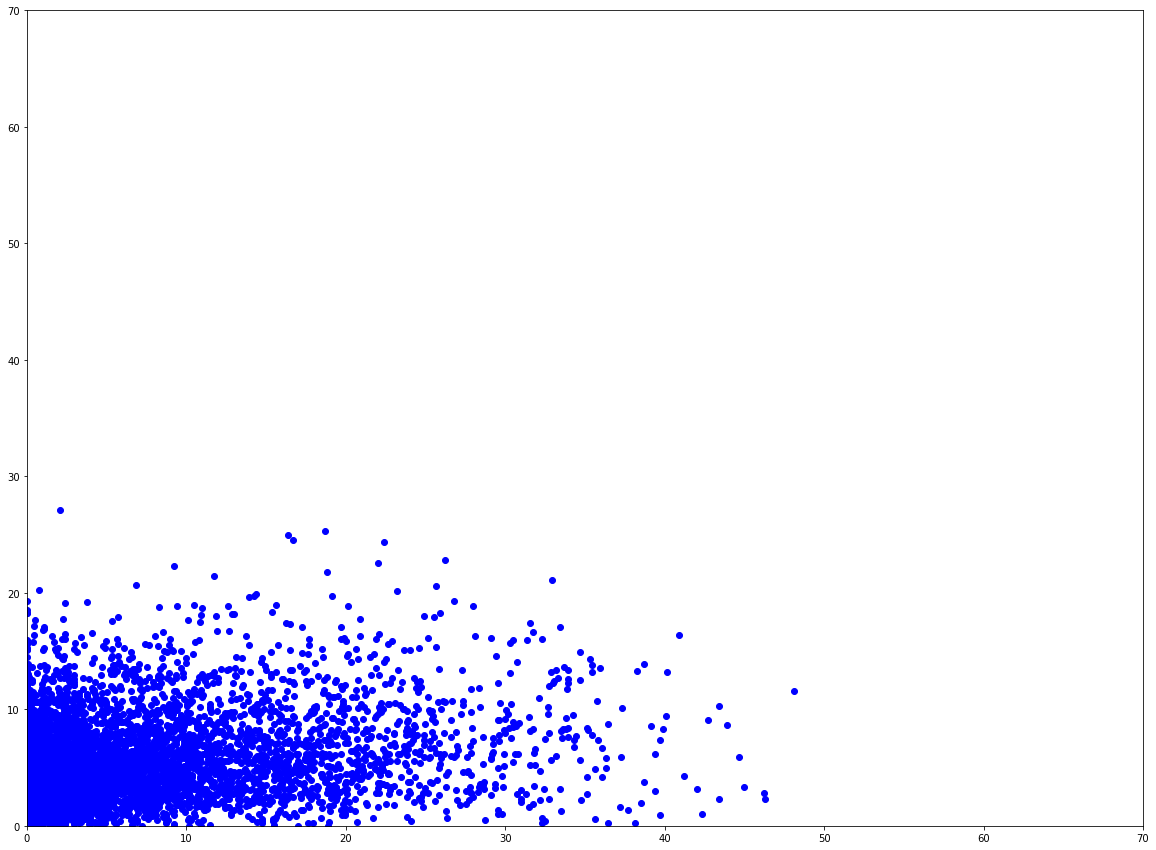

6.123159373010845


In [434]:
# div 추가한 결과

from sklearn.metrics import mean_squared_error as mse
plt.figure(figsize=(20,15))

plt.plot(pred['total_spent'],pred['pred'],'bo')
plt.axis([0, 70, 0, 70]); plt.show()
linreg_RMSE = np.sqrt(mse(pred['pred'], pred['total_spent']))
print(linreg_RMSE)

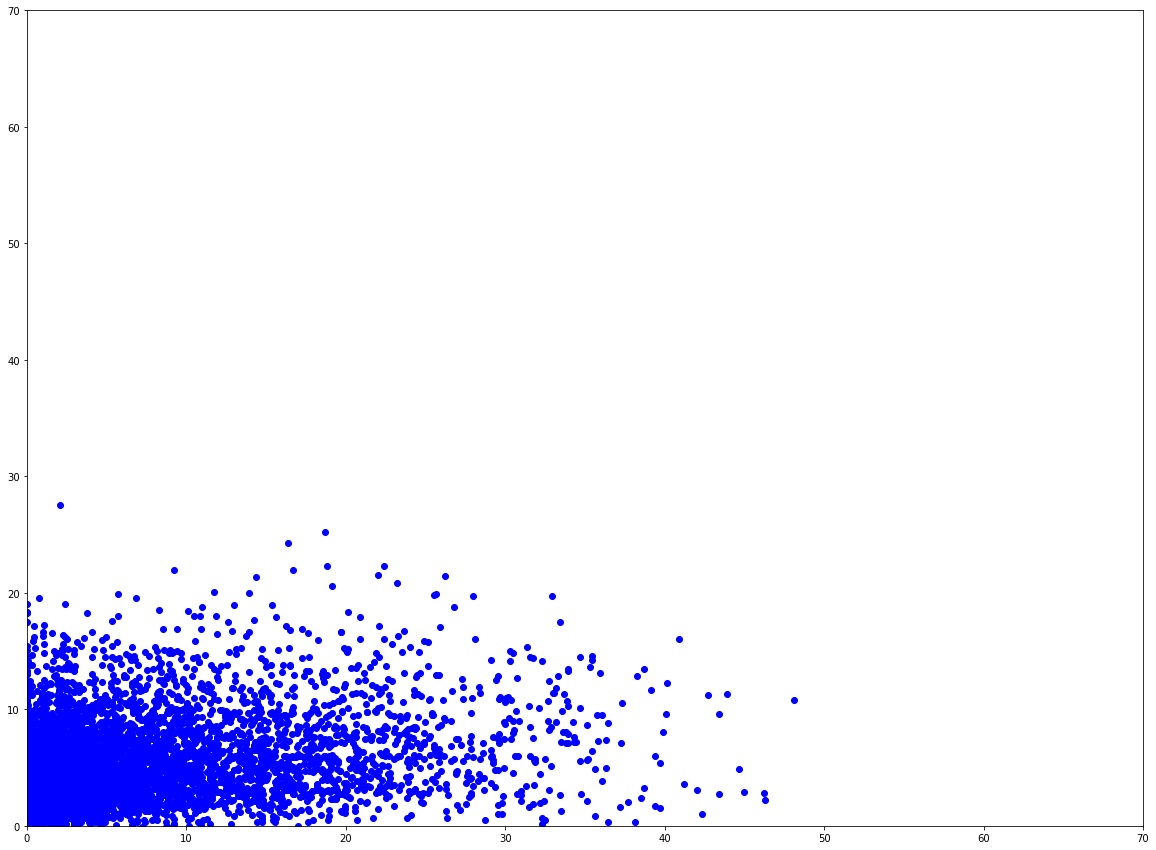

6.117569192225427


In [384]:
# 주캐 ,부캐 따로 한 변수만 가지고 평가한 결과
from sklearn.metrics import mean_squared_error as mse
plt.figure(figsize=(20,15))
plt.plot(pred['total_spent'],pred['pred'],'bo')
plt.axis([0, 70, 0, 70]); plt.show()
linreg_RMSE = np.sqrt(mse(pred['pred'], pred['total_spent']))
print(linreg_RMSE)